In [1]:
import torch
import torchvision
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.7.1+cu128
torchvision version: 0.22.1+cu128


In [2]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [3]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [4]:
"""
Contains functionality for creating PyTorch DataLoaders for 
image classification data.
"""
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [5]:
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [6]:
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f4734deed20>,
 ['pizza', 'steak', 'sushi'])

In [7]:
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

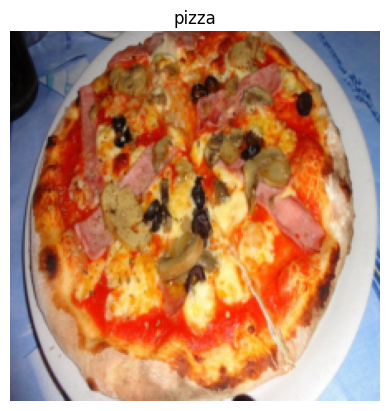

In [8]:
import matplotlib.pyplot as plt
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [9]:
import torch

In [10]:
height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = int((height * width)/ patch_size**2)

In [11]:
number_of_patches

196

In [12]:
conv2d = torch.nn.Conv2d(in_channels=3,
                         out_channels=768,
                         kernel_size=patch_size,
                         stride=patch_size,
                         padding=0)

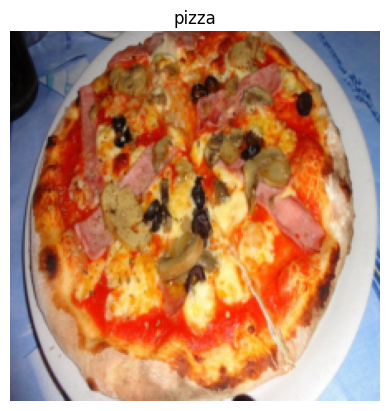

In [13]:
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

In [14]:
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


In [15]:
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.0886,  0.1327,  0.1047,  0.1236,  0.2493,  0.1070,  0.2296,
            0.0879,  0.0212,  0.0790,  0.1111,  0.3485,  0.1689,  0.1785],
          [ 0.0142,  0.0400,  0.1298,  0.3894,  0.1186,  0.1159,  0.0298,
            0.1607,  0.1433,  0.1425,  0.2116,  0.2049,  0.2875,  0.2018],
          [-0.0037,  0.0933,  0.2534,  0.1635,  0.1412,  0.0621,  0.2728,
            0.0786,  0.1784,  0.0993,  0.2094,  0.0646,  0.3854,  0.1796],
          [ 0.0467,  0.1299,  0.0789,  0.2382, -0.1517,  0.2391,  0.2455,
            0.1563,  0.1332,  0.0653,  0.2418, -0.0253,  0.2577,  0.3608],
          [ 0.1732,  0.1881,  0.0499,  0.1073, -0.0021,  0.1746,  0.3151,
            0.4087,  0.2284, -0.0240,  0.1766,  0.1384,  0.2235,  0.4422],
          [ 0.1391,  0.1325,  0.0354,  0.0645,  0.1014,  0.2738,  0.0472,
            0.0881,  0.3363,  0.2245,  0.1601,  0.1391,  0.3189,  0.4205],
          [ 0.1669,  0.0502,  0.0794,  0.1831,  0.2543,  0.1026,  0.3186,
           -0.0143,  0.2547,  0.

In [16]:
class PatchEmbedding(torch.nn.Module):
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        self.patcher = torch.nn.Conv2d(in_channels=in_channels,
                                       out_channels=embedding_dim,
                                       kernel_size=patch_size,
                                       padding=0)
        
        self.flatten = torch.nn.Flatten(start_dim=2,
                                        end_dim=3)
        
    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution%patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        return x_flattened.permute(0, 2, 1)
        